<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Brg1KD_scRNA_seq_D7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of day 7 single-cell RNA-seq data of Etv2 induced reprogramming

by Wuming Gong



In [1]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c('SummarizedExperiment', 'rhdf5', 'SingleCellExperiment'), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘XVector’, ‘matrixStats’, ‘RCurl’, ‘GenomeInfoDbData’, ‘GenomicRanges’, ‘Biobase’, ‘DelayedArray’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘Rhdf5lib’


Old packages: 'broom', 'foreign'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘sitmo’, ‘globals’, ‘listenv’, ‘plyr’, ‘zoo’, ‘hexbin’, ‘data.table’, ‘rappdirs’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘goftest’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘


✔  checking for file ‘/tmp/RtmpzKIz9i/remotes6c522e5108/rstudio-reticulate-b1604eb/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.16-9001.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(Seurat)
library(rhdf5)
library(Matrix)
library(SummarizedExperiment)
library(SingleCellExperiment)
library(tidyverse)
library(farver)
library(scales) # hue_pal
theme_set(theme_bw())

Registered S3 method overwritten by 'spatstat':
  method     from
  print.boxx cli 

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rb

In [4]:
dirs <- c(
  'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/190401_A00223_0099_BH5WJCDRXX/Garry_Project_065/Analysis/cellranger-Garry_065_01-combined',
  'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/190319_A00223_0092_BH73WLDRXX/Garry_Project_065/Analysis/cellranger-Garry_065_02',
  'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/200825_A00223_0395_BH3H2HDSXY/Garry_Project_080/Analysis/cellranger-Garry_080_D7_DOX_FL',
  'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/200825_A00223_0395_BH3H2HDSXY/Garry_Project_080/Analysis/cellranger-Garry_080_D7_NODOX_FL'
)

## Download the barcode files

In [5]:
barcode_files <- sprintf('%s/filtered_feature_bc_matrix.h5', dirs)
cat('remote filtered_feature_bc_matrix files:\n')
print(barcode_files)
local_barcode_files <- gsub('https://s3.msi.umn.edu/', './', barcode_files)
cat('local filtered_feature_bc_matrix files:\n')
print(local_barcode_files)
commands <- sprintf('wget -x -c -nH %s', barcode_files)
for (command in commands) system(command)
file.exists(local_barcode_files)

remote filtered_feature_bc_matrix files:
[1] "https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/190401_A00223_0099_BH5WJCDRXX/Garry_Project_065/Analysis/cellranger-Garry_065_01-combined/filtered_feature_bc_matrix.h5"
[2] "https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/190319_A00223_0092_BH73WLDRXX/Garry_Project_065/Analysis/cellranger-Garry_065_02/filtered_feature_bc_matrix.h5"         
[3] "https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/200825_A00223_0395_BH3H2HDSXY/Garry_Project_080/Analysis/cellranger-Garry_080_D7_DOX_FL/filtered_feature_bc_matrix.h5"  
[4] "https://s3.msi.umn.edu/gongx030/data_release/umgc/novaseq/200825_A00223_0395_BH3H2HDSXY/Garry_Project_080/Analysis/cellranger-Garry_080_D7_NODOX_FL/filtered_feature_bc_matrix.h5"
local filtered_feature_bc_matrix files:
[1] "./gongx030/data_release/umgc/novaseq/190401_A00223_0099_BH5WJCDRXX/Garry_Project_065/Analysis/cellranger-Garry_065_01-combined/filtered_feature_bc_matrix.h5"
[2] "./gongx030/data

[1] TRUE TRUE TRUE TRUE

## Read the raw read count matrix

In [6]:
so <- lapply(1:length(local_barcode_files), function(i){ 
  barcodes <- h5read(local_barcode_files[i], 'matrix/barcodes')
  data <- h5read(local_barcode_files[i], 'matrix/data')
  shape <- h5read(local_barcode_files[i], 'matrix/shape')
  indices <- h5read(local_barcode_files[i], 'matrix/indices')
  indptr <- h5read(local_barcode_files[i], 'matrix/indptr')
  feature_type <- as.character(h5read(local_barcode_files[i], 'matrix/features/feature_type'))
  genome <- as.character(h5read(local_barcode_files[i], 'matrix/features/genome'))
  id <- as.character(h5read(local_barcode_files[i], 'matrix/features/id'))
  name <- as.character(h5read(local_barcode_files[i], 'matrix/features/name'))
  sparseMatrix(i = indices + 1, j = rep(1:shape[2], diff(indptr)), x = data, dims = shape, dimnames = list(name, barcodes))
})
names(so) <- names(dirs)

In [7]:
for (i in 1:length(so)){
  cat(sprintf('condition=%s | number of features=%d | number of cells=%d\n', names(so)[i], nrow(so[[i]]), ncol(so[[i]])))
}

condition=MEF_Dox_D7 | number of features=31053 | number of cells=8922
condition=MEF_Dox_D7_Flk1pos | number of features=31053 | number of cells=1506
condition=MEF_Brg1_KD_Dox_D7 | number of features=31053 | number of cells=8518
condition=MEF_Brg1_KD_NoDox_D7 | number of features=31053 | number of cells=8601


In [8]:
so <- lapply(names(so), function(i) {
  X <- so[[i]]
  X <- X[order(rowSums(X), decreasing = TRUE), ]
  X <- X[!duplicated(rownames(X)), ] # remove duplicated rownames
  y <- CreateSeuratObject(counts = X, min.cells = 3, min.features = 200, project = i)
  y[["percent.mt"]] <- PercentageFeatureSet(y, pattern = "^mt-")
  y[["percent.rpl"]] <- PercentageFeatureSet(y, pattern = "^Rpl")
  y[["percent.rps"]] <- PercentageFeatureSet(y, pattern = "^Rps")
  y
})
names(so) <- names(dirs)

In [9]:
ps <- lapply(1:length(so), function(i) VlnPlot(so[[i]], c("nCount_RNA", "nFeature_RNA", 'percent.mt', 'percent.rpl', 'percent.rps'), pt.size = 0.1, ncol = 5))

We used patchwork to combine multiple figures made by ggplot2 (e.g. https://cmdlinetips.com/2020/01/tips-to-combine-multiple-ggplots-using-patchwork/)

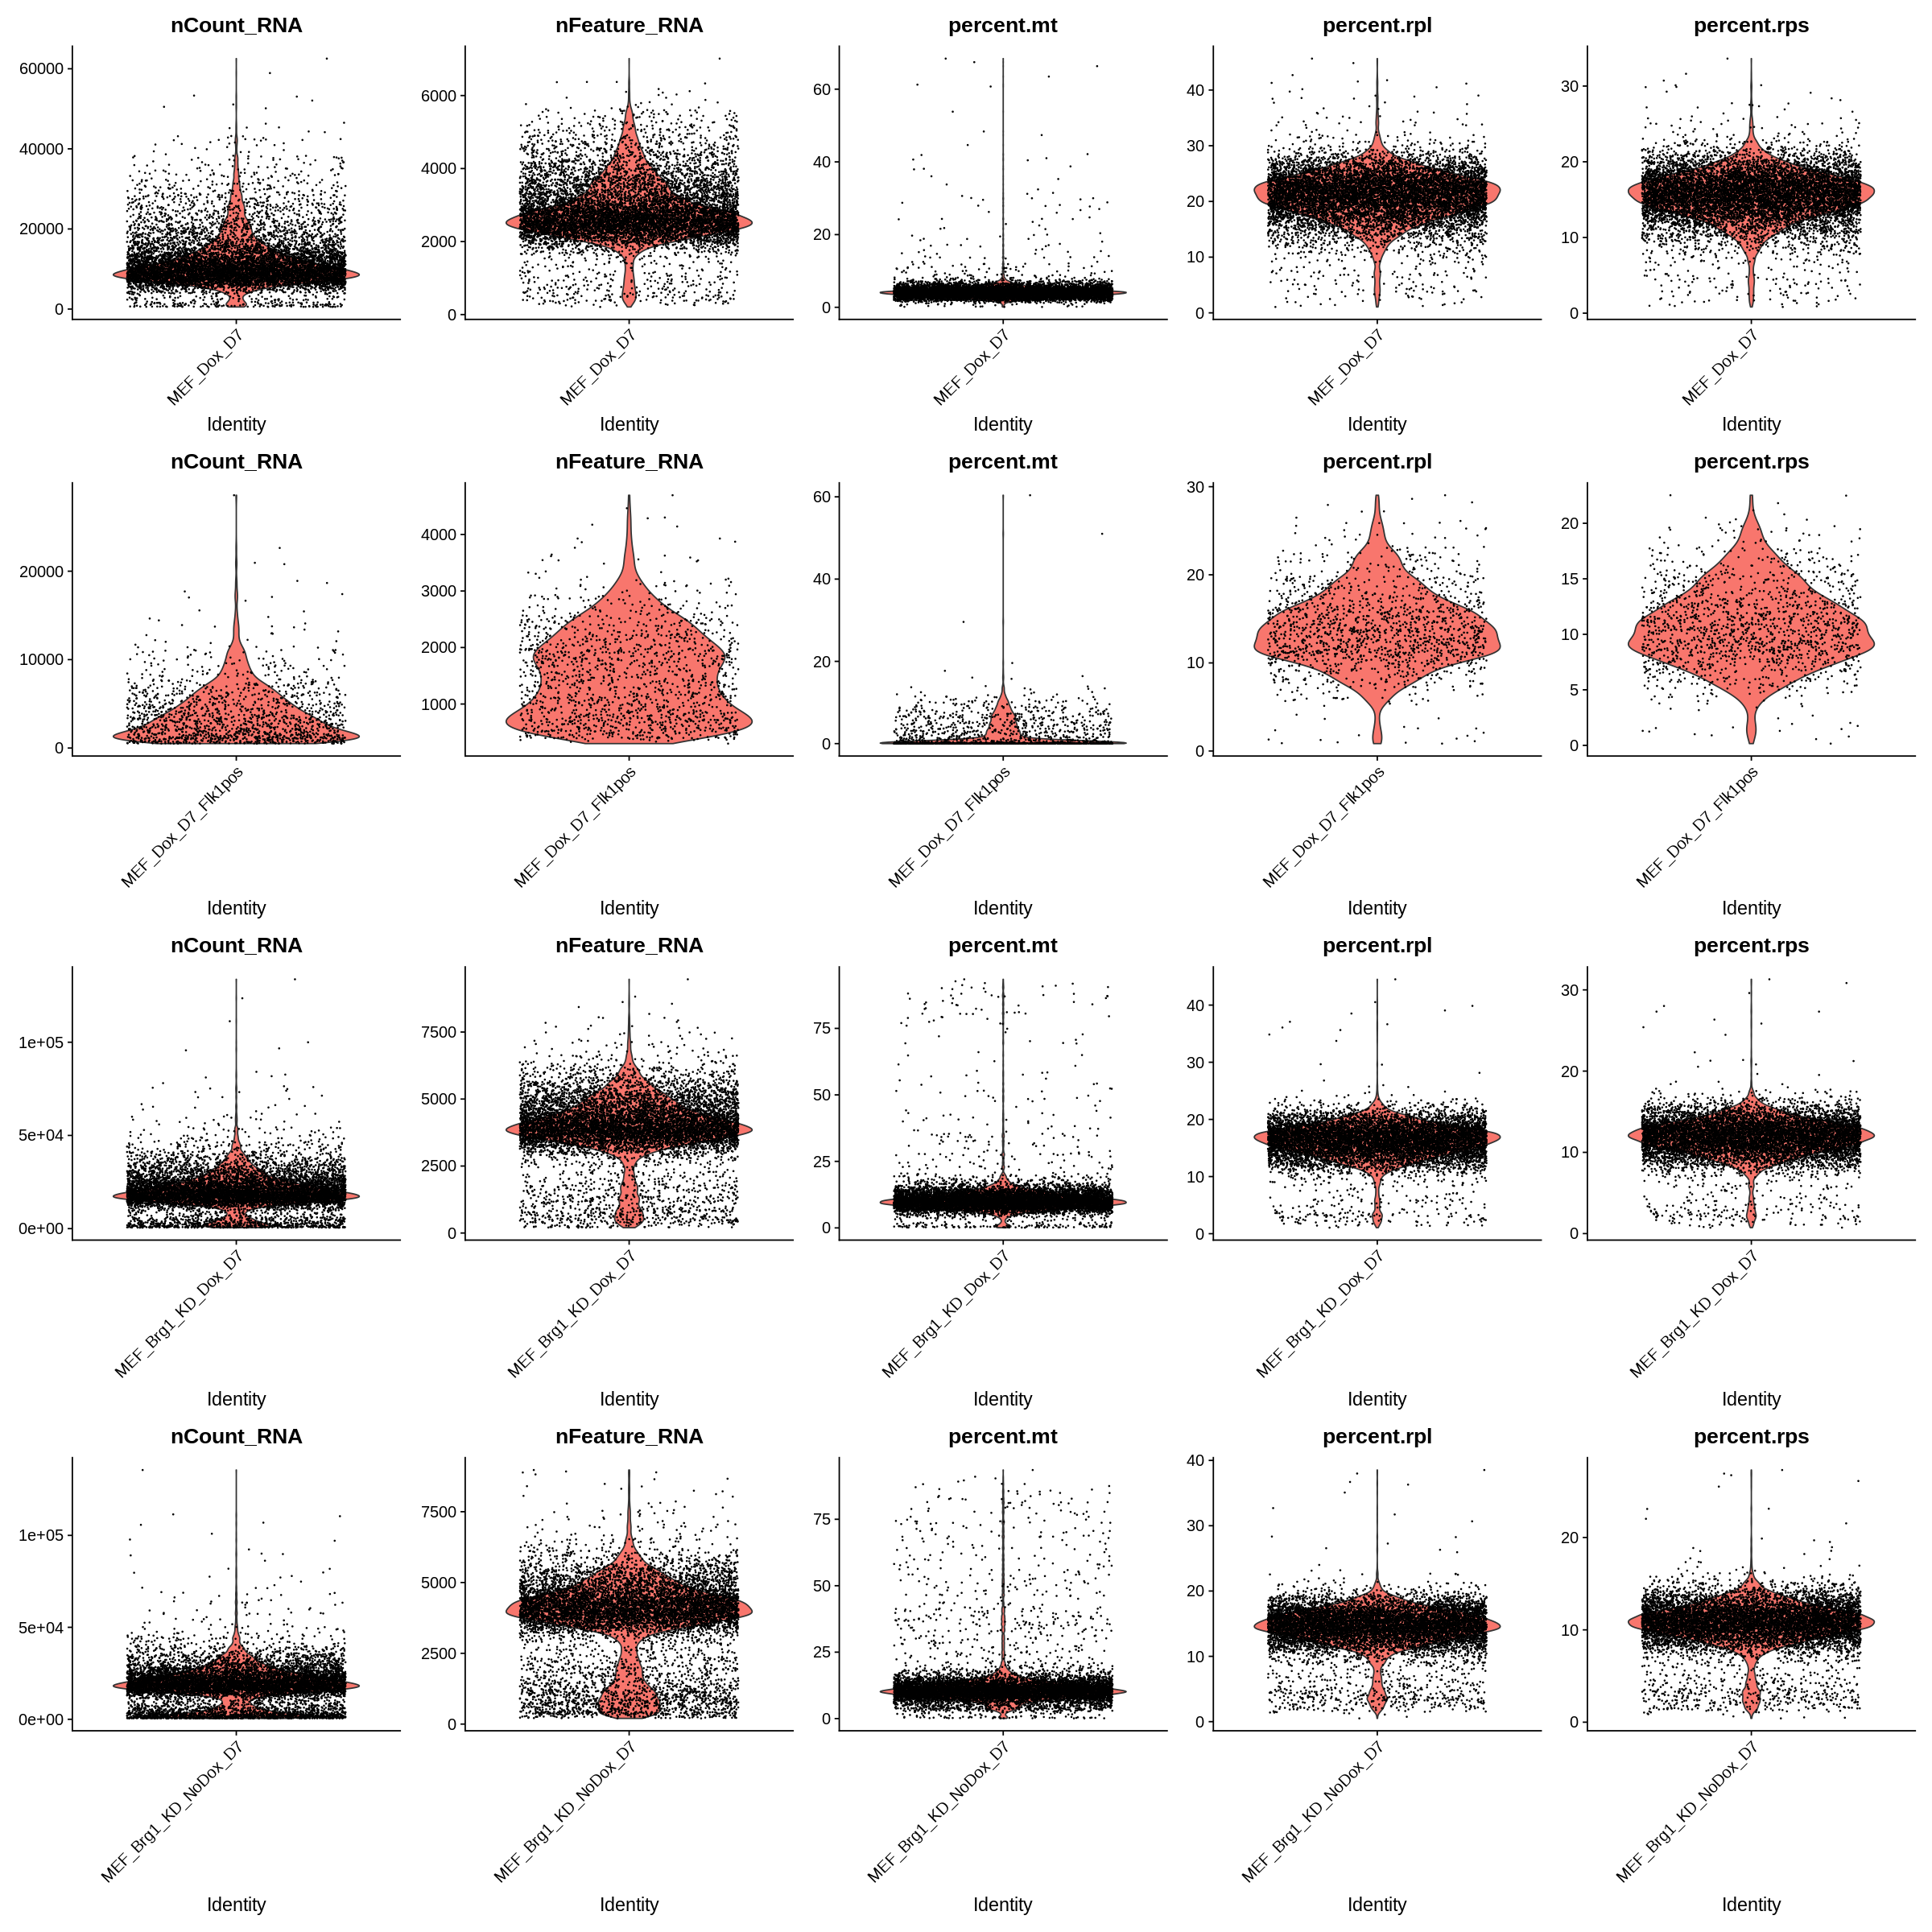

In [10]:
options(repr.plot.width = 20, repr.plot.height = 5 * length(ps))
Reduce('/', ps)

In [11]:
for (i in 1:length(so)){
  so_i <- subset(so[[i]], nFeature_RNA > 200 & percent.mt < 20)
  cat(sprintf('%s | number of cels=%d | number of cells after filtering=%d | percent remaining cells=%3.f%%\n', names(so)[i], ncol(so[[i]]), ncol(so_i), ncol(so_i) / ncol(so[[i]]) * 100))
  so[[i]] <- so_i
}
names(so) <- names(dirs)

MEF_Dox_D7 | number of cels=8890 | number of cells after filtering=8838 | percent remaining cells= 99%
MEF_Dox_D7_Flk1pos | number of cels=1505 | number of cells after filtering=1502 | percent remaining cells=100%
MEF_Brg1_KD_Dox_D7 | number of cels=8486 | number of cells after filtering=8248 | percent remaining cells= 97%
MEF_Brg1_KD_NoDox_D7 | number of cels=8556 | number of cells after filtering=8034 | percent remaining cells= 94%


## Analysis of D7 single cells (Dox and No Dox)
`MEF_Dox_D7`: MEF reprogramming at 7 days post Etv2 induction

`MEF_Dox_D7_Flk1pos`: MEF reprogramming at 7 days post Etv2 induction (Flk1+ cells only)

`MEF_Brg1_KD_Dox_D7`: Brg1 KD MEF reprogramming at 7 days post Etv2 induction.  

`MEF_Brg1_KD_NoDox_D7`: Brg1 KD MEF at day 7 control

In [12]:
# Merge multiple Seurat objects
conditions <- c('MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos', 'MEF_Brg1_KD_Dox_D7', 'MEF_Brg1_KD_NoDox_D7')
so_D7b <- merge(so[['MEF_Dox_D7']], c(so[['MEF_Dox_D7_Flk1pos']], so[['MEF_Brg1_KD_Dox_D7']], so[['MEF_Brg1_KD_NoDox_D7']]), add.cell.ids = conditions, project = 'D7b')

In [13]:
cat(sprintf('number of total features=%d | number of total cells=%d\n', nrow(so_D7b), ncol(so_D7b)))

number of total features=18654 | number of total cells=26622


In [14]:
table(so_D7b$orig.ident)


  MEF_Brg1_KD_Dox_D7 MEF_Brg1_KD_NoDox_D7           MEF_Dox_D7 
                8248                 8034                 8838 
  MEF_Dox_D7_Flk1pos 
                1502 

### Preprocess the raw read counts by `Seurat`.

In [15]:
so_D7b <- so_D7b %>%
  NormalizeData() %>%
  ScaleData()

Centering and scaling data matrix



Select top variable genes.

In [16]:
so_D7b <- FindVariableFeatures(so_D7b, selection.method = 'vst')

See how number of total counts and number of genes expressed are distributed.

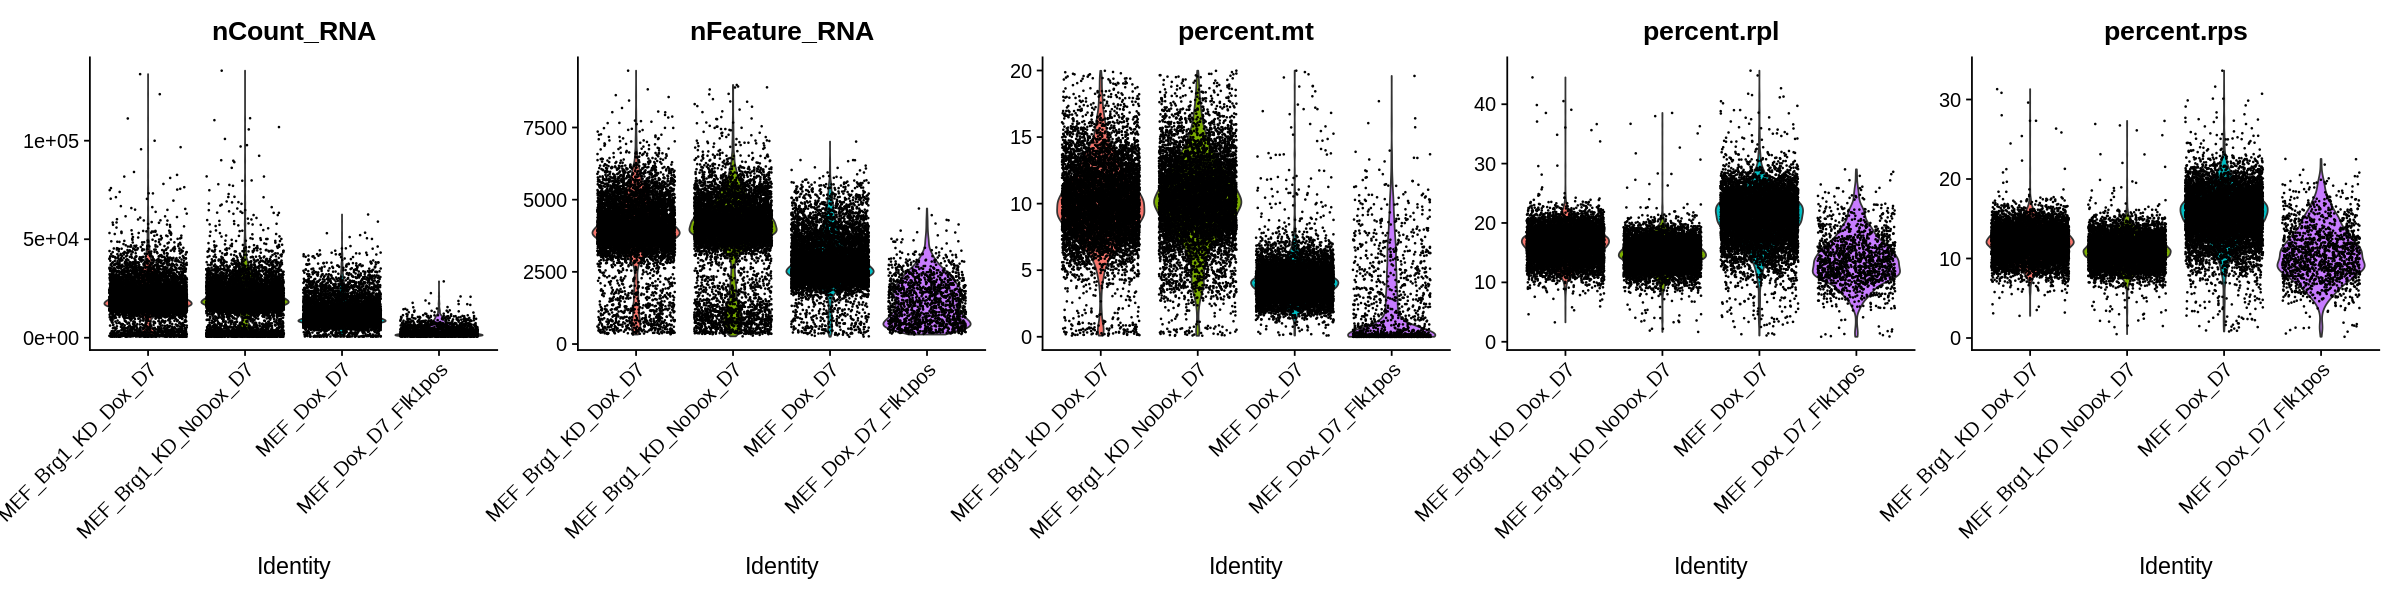

In [17]:
options(repr.plot.width = 20, repr.plot.height = 5)
VlnPlot(so_D7b, c("nCount_RNA", "nFeature_RNA", 'percent.mt', 'percent.rpl', 'percent.rps'), pt.size = 0.1, ncol = 5)

### Cell cycle scoring analysis

In [18]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
substring(s.genes, 2) <- tolower(substring(s.genes, 2))
substring(g2m.genes, 2) <- tolower(substring(g2m.genes, 2))

In [19]:
so_D7b <- CellCycleScoring(so_D7b, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
# view cell cycle scores and phase assignments
head(so_D7b[[]])

Warning message:
“The following features are not present in the object: Mlf1ip, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA percent.mt
MEF_Dox_D7_AAACCTGAGTCACGCC-1 MEF_Dox_D7  8381      2565         3.543730  
MEF_Dox_D7_AAACCTGCATCAGTCA-1 MEF_Dox_D7 17250      3820         4.649275  
MEF_Dox_D7_AAACCTGCATTGGTAC-1 MEF_Dox_D7 37384      4998         1.915258  
MEF_Dox_D7_AAACCTGGTAGCCTCG-1 MEF_Dox_D7  8498      2281         3.847964  
MEF_Dox_D7_AAACCTGGTCTTCGTC-1 MEF_Dox_D7  8328      2459         3.866475  
MEF_Dox_D7_AAACCTGGTTACGGAG-1 MEF_Dox_D7 23523      4363         3.137355  
                              percent.rpl percent.rps S.Score     G2M.Score  
MEF_Dox_D7_AAACCTGAGTCACGCC-1 19.52034    14.67605    -0.06175930 -0.01896840
MEF_Dox_D7_AAACCTGCATCAGTCA-1 21.53043    15.18841    -0.04148211  0.02291161
MEF_Dox_D7_AAACCTGCATTGGTAC-1 24.05307    17.36572     0.15858740  0.41552865
MEF_Dox_D7_AAACCTGGTAGCCTCG-1 22.11108    17.49823    -0.04184626  0.01164674
MEF_Dox_D7_AAACCTGGTCTTCGTC-1 17.08694    13.49664    -0.06120560 -0.05982753
MEF_Dox_D7_AAACCTGGTTACGGAG-1 21.95723    17.02164     0.24278250  0.38184818
                              Phase old.ident 
MEF_Dox_D7_AAACCTGAGTCACGCC-1 G1    MEF_Dox_D7
MEF_Dox_D7_AAACCTGCATCAGTCA-1 G2M   MEF_Dox_D7
MEF_Dox_D7_AAACCTGCATTGGTAC-1 G2M   MEF_Dox_D7
MEF_Dox_D7_AAACCTGGTAGCCTCG-1 G2M   MEF_Dox_D7
MEF_Dox_D7_AAACCTGGTCTTCGTC-1 G1    MEF_Dox_D7
MEF_Dox_D7_AAACCTGGTTACGGAG-1 G2M   MEF_Dox_D7

In [20]:
so_D7b <- RunPCA(so_D7b, features = VariableFeatures(so_D7b))

PC_ 1 
Positive:  Cxcl12, Prdx4, mt-Co2, Ldhb, mt-Nd3, Fth1, Gabarap, Col1a2, Aspn, Gas6 
	   mt-Nd5, Lxn, mt-Nd2, Dcxr, mt-Nd4l, Emc2, mt-Cytb, Tspo, Emb, Gm10076 
	   Ifi27, Npc2, Ogn, Col1a1, mt-Atp6, mt-Nd4, Mmp2, Igf1, Clu, Ccdc80 
Negative:  Rpl13a, Rps27rt, Rpl23a, Emp1, Rpl36al, Rpl4, Snhg6, Pfn1, Pdap1, Glud1 
	   Snrpf, AC160336.1, Hprt, Hmga2, Usp50, Tpm4, Hmgn5, Thy1, Nptx1, Jade1 
	   Odc1, Eif2s2, Xylt1, Smpd3, Plscr2, Ddx21, Snhg9, Smarca4, Nmt2, F2r 
PC_ 2 
Positive:  Pclaf, Top2a, Birc5, Ube2c, Ccna2, Hmgb2, Cdca3, Sgo1, Prc1, Hist1h2ap 
	   Tpx2, Cenpf, Cenpm, Anln, Pimreg, Spc24, Hmmr, Stmn1, Cenpe, H2afz 
	   Tk1, Nusap1, Mki67, Kif23, Smc2, Racgap1, Ccnb2, Cenpa, Nuf2, Ckap2l 
Negative:  Ptn, Ebf2, Nr2f1, Selenop, Gpm6b, Plscr2, Mest, Rgs2, Col3a1, Smpd3 
	   Adgrf5, Smoc2, Atp1b1, Tgfbi, Xylt1, Rnf128, Cpe, Otor, Glud1, Slco2a1 
	   Ngf, Akap12, F2r, Plagl1, Emilin2, Fgf1, Thbs1, Slfn5, Malat1, Slc16a2 
PC_ 3 
Positive:  Col1a1, Lox, Sfrp1, Gas1, Ahnak, Marcks, Me

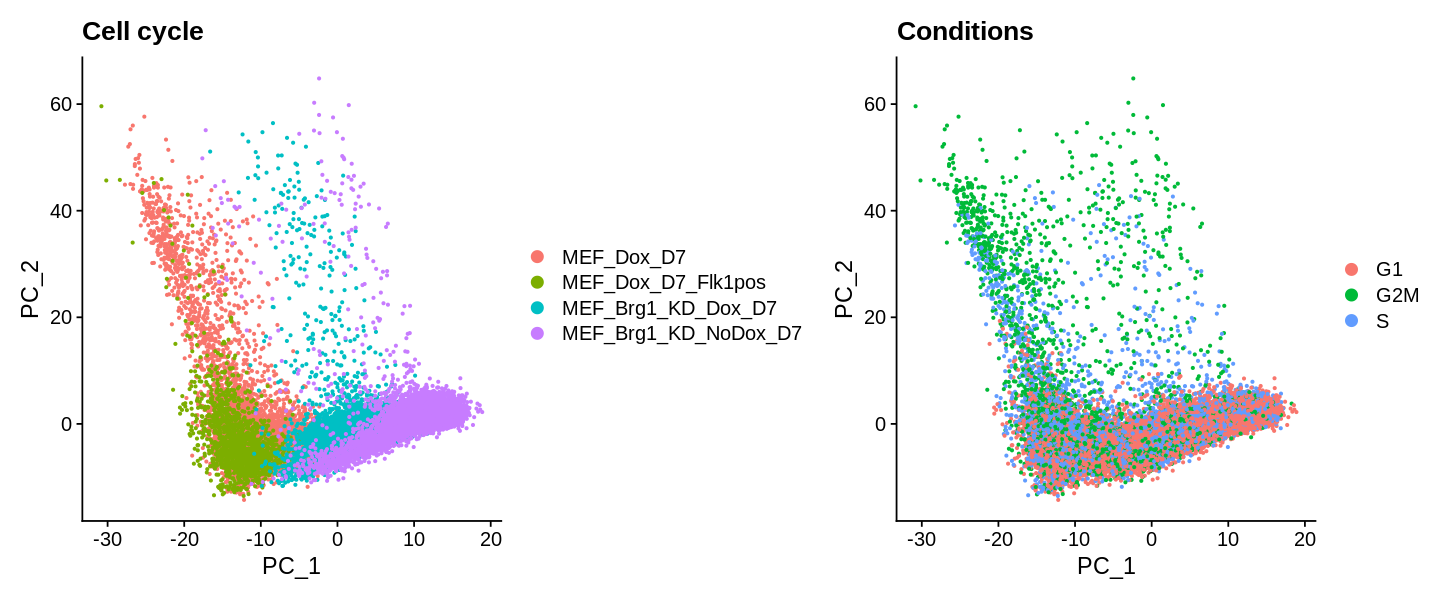

In [21]:
options(repr.plot.width = 12, repr.plot.height = 5)
Idents(so_D7b) <- 'orig.ident'
p1 <- DimPlot(so_D7b, reduction = "pca", pt.size = 0.5) + ggtitle(label = "Cell cycle")
Idents(so_D7b) <- 'Phase'
p2 <- DimPlot(so_D7b, reduction = "pca", pt.size = 0.5) + ggtitle(label = "Conditions")
p1 + p2

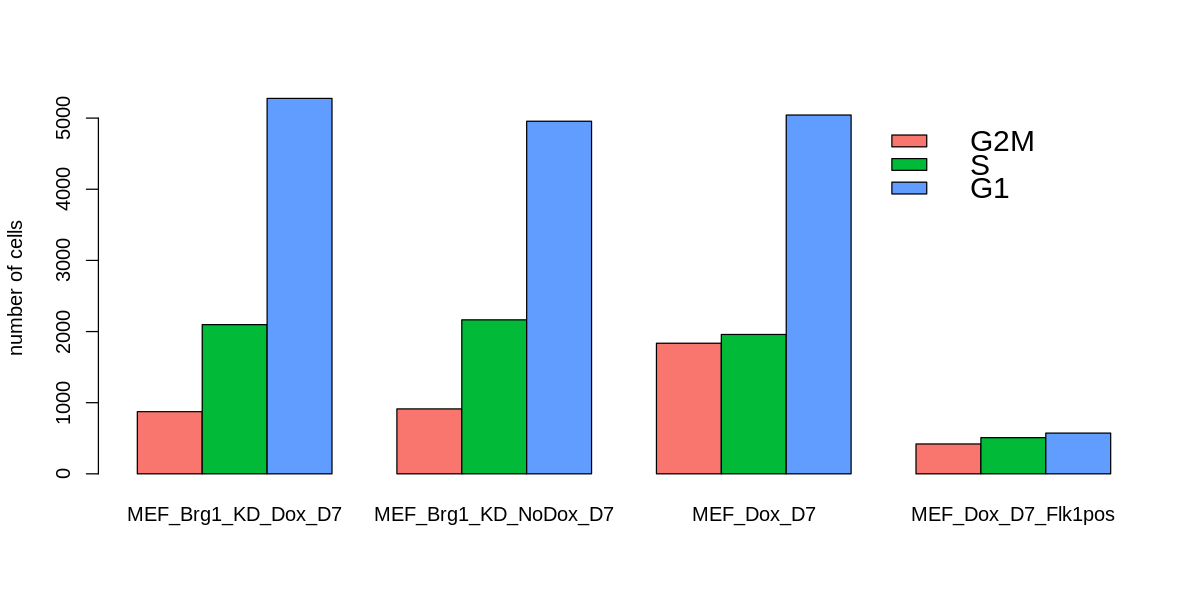

In [22]:
options(repr.plot.width = 10, repr.plot.height = 5)
table(so_D7b[[]][, 'orig.ident'], factor(so_D7b[[]][, 'Phase'], c('G2M', 'S', 'G1'))) %>% 
  t() %>%
  barplot(beside = TRUE, col = hue_pal()(3), ylab = 'number of cells')
legend('topright', c('G2M', 'S', 'G1'), fill = hue_pal()(3), bty = 'n', cex = 1.5, inset = 0.05)

### Regress out the confounding effects

In [23]:
so_D7b <- ScaleData(object = so_D7b, vars.to.regress = c('nCount_RNA', "nFeature_RNA", 'percent.mt', 'percent.rpl', 'percent.rps', "S.Score", "G2M.Score"))

Regressing out nCount_RNA, nFeature_RNA, percent.mt, percent.rpl, percent.rps, S.Score, G2M.Score

Centering and scaling data matrix



In [24]:
so_D7b <- FindVariableFeatures(so_D7b, selection.method = 'vst', nfeatures = 2000)
so_D7b <- RunPCA(so_D7b, features = VariableFeatures(so_D7b))

PC_ 1 
Positive:  Cxcl12, Col1a1, Prdx4, Fth1, Ogn, Gas6, Col1a2, Aspn, Wfdc18, Npc2 
	   Vcan, S100a10, S100a11, Clca3a2, Cdh11, Srpx, Emb, Vim, Clec11a, Lypd1 
	   Ldhb, Lox, Lxn, Igf1, Ccdc80, Gas1, Lgals1, Islr, C3, Prrx2 
Negative:  Glud1, Emp1, Adgrf5, Ctla2a, Hprt, Odc1, Rgs2, Ngf, Nrp1, Itga6 
	   Xylt1, Hmgb3, Akap12, Rhoj, Ifi203, Plscr2, Gcc2, Cep250, F2r, Cdh5 
	   Ptpn18, Rnf128, Emcn, Otor, Kdr, Pnp, Fgf1, Raph1, Cd53, Cdk18 
PC_ 2 
Positive:  Pnp, Ifitm3, Atp5h, Ckb, Maged2, Etfb, Tmem176b, Prdx2, G0s2, Dbi 
	   Ubb, Ifi203, Psmb5, Ctsh, Vcam1, Atp1b1, Cpe, Mgp, Ptpn18, Ndufa4 
	   Ifi27, Cd24a, Mest, Tmem176a, Tgfbi, Ptn, Vamp5, Gsta4, Ier2, Tm4sf1 
Negative:  Ankrd1, Hmga2, Dpysl3, Lgals3, Dkk2, Thy1, Cd44, Tinagl1, Wincr1, Fosl1 
	   Ahnak, Arhgap22, Areg, Hbegf, Tnfrsf12a, Etv4, Rpl23a, Hmga1, Htra1, Igfbp6 
	   Kcnn4, Hmga1b, Col8a1, AC160336.1, Cdkn2a, Ncam1, Mapk6, Bok, Ano1, Ltbp1 
PC_ 3 
Positive:  Thbs1, Malat1, Marcks, Smpd3, Ebf2, Mest, Nr2f1, Adamts5, Cyp1b1

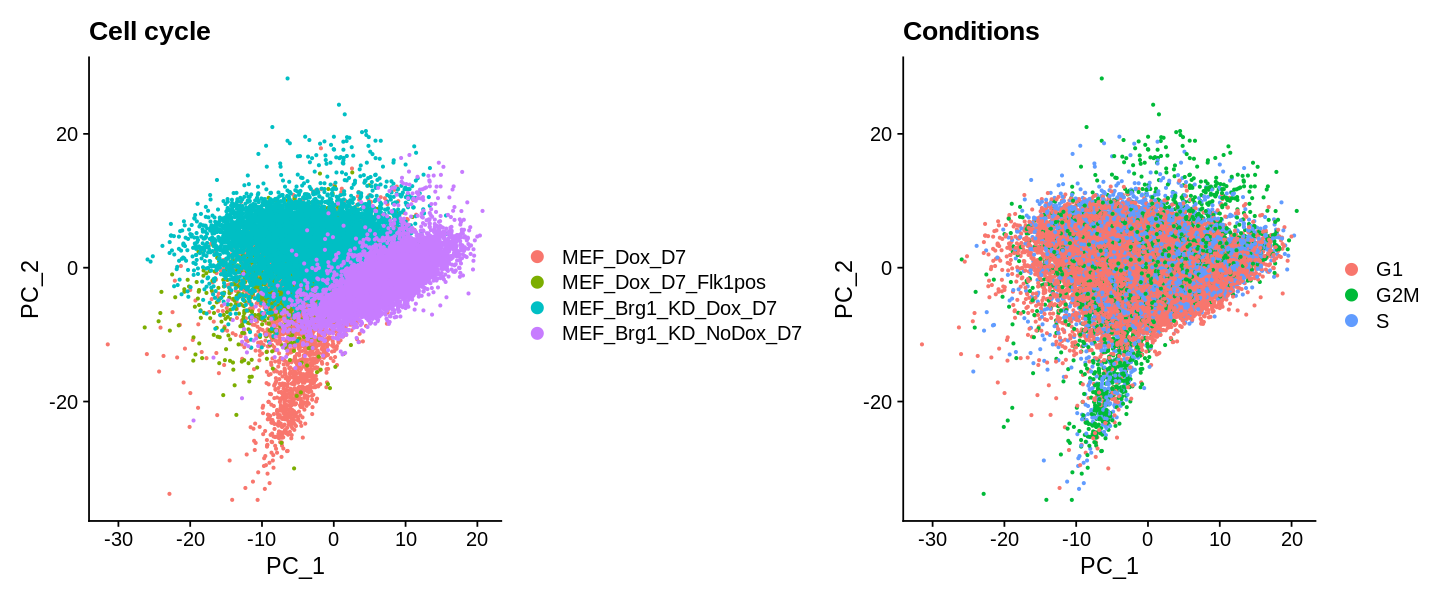

In [25]:
options(repr.plot.width = 12, repr.plot.height = 5)
Idents(so_D7b) <- 'orig.ident'
p1 <- DimPlot(so_D7b, reduction = "pca", pt.size = 0.5) + ggtitle(label = "Cell cycle")
Idents(so_D7b) <- 'Phase'
p2 <- DimPlot(so_D7b, reduction = "pca", pt.size = 0.5) + ggtitle(label = "Conditions")
p1 + p2

### Dimension reduction

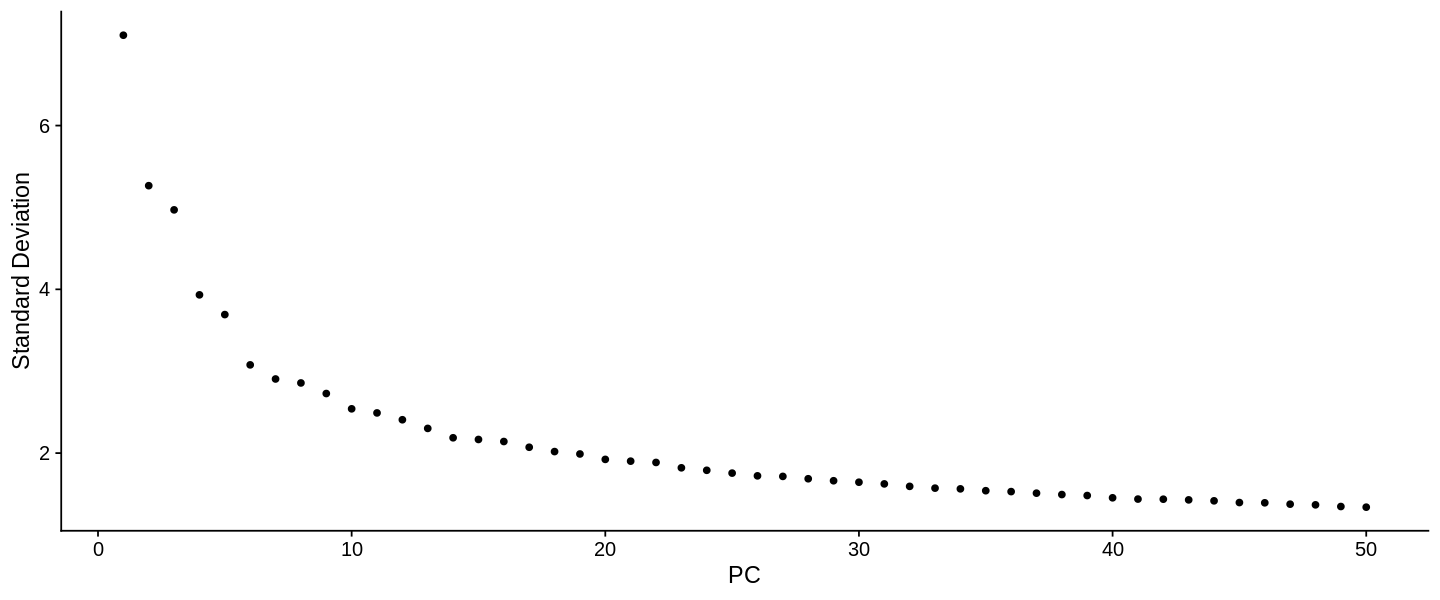

In [26]:
ElbowPlot(so_D7b, ndims = 50)

In [27]:
so_D7b <- RunUMAP(so_D7b, reduction = 'pca', dims = 1:50, min.dist = 0.75, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [28]:
# Leiden clustering
so_D7b <- FindNeighbors(so_D7b, reduction = 'umap', dims = 1:2)
so_D7b <- FindClusters(so_D7b, algorithm = 1, resolution = 0.15)
# store the current identities in a new column of meta.data called cluster
so_D7b$cluster <- Idents(so_D7b)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26622
Number of edges: 598088

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9717
Number of communities: 13
Elapsed time: 1 seconds


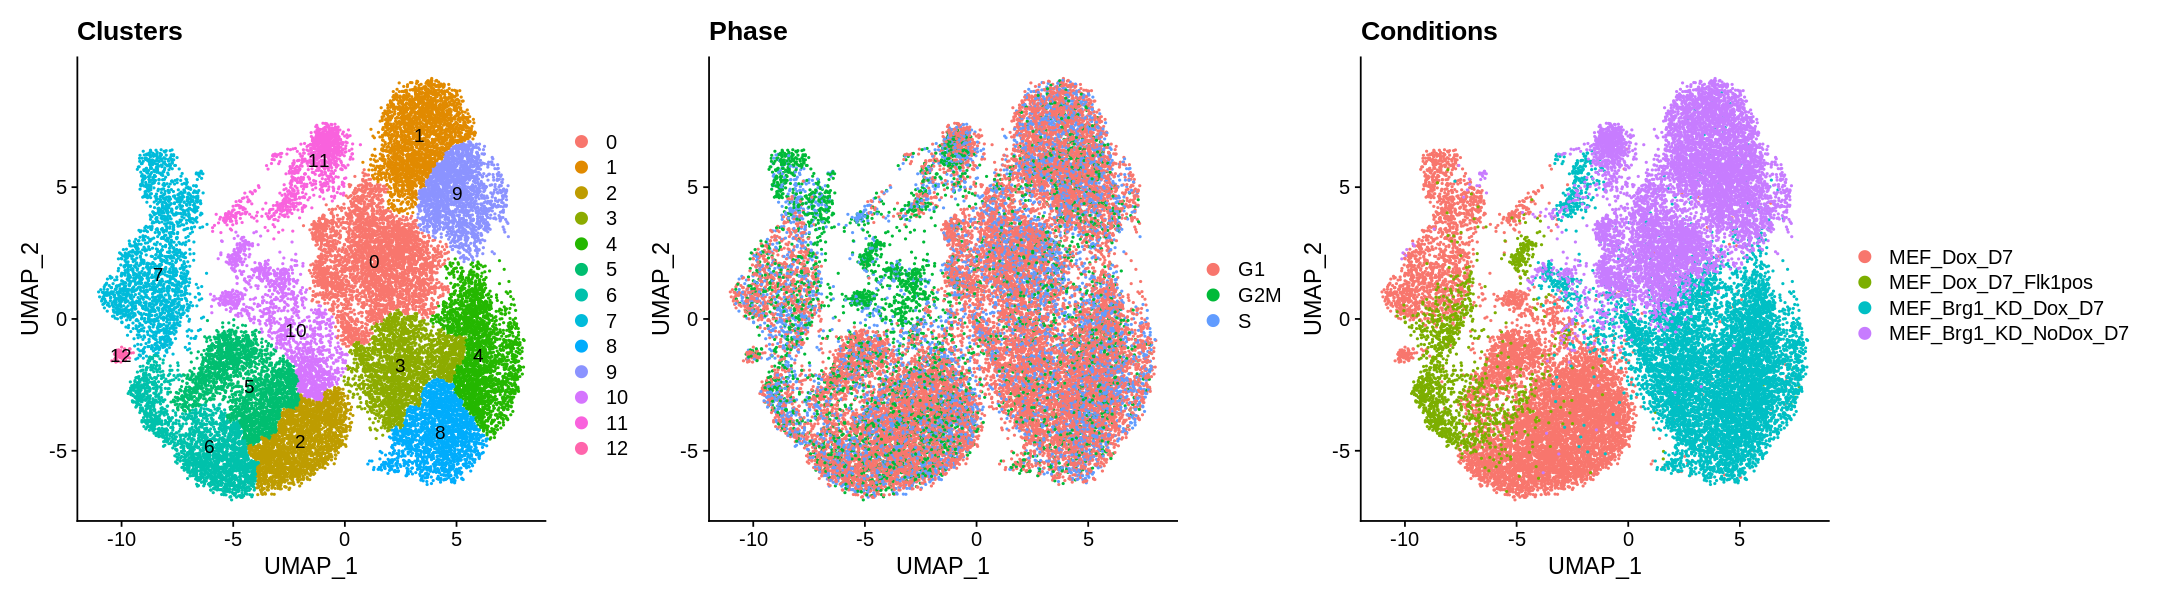

In [29]:
library(ggplot2)
options(repr.plot.width = 18, repr.plot.height = 5)
Idents(so_D7b) <- 'cluster'
p1 <- DimPlot(so_D7b, reduction = "umap", pt.size = 0.25, label = TRUE) + ggtitle(label = "Clusters")
Idents(so_D7b) <- 'Phase'
p2 <- DimPlot(so_D7b, reduction = "umap", pt.size = 0.25) + ggtitle(label = "Phase")
Idents(so_D7b) <- 'orig.ident'
p3 <- DimPlot(so_D7b, reduction = "umap", pt.size = 0.25) + ggtitle(label = "Conditions")
p1 + p2 + p3

In [30]:
genes <- c('Etv2', 'Kdr', 'Emcn', 'Lmo2', 'Cdh5', 'Sox18', 'Smarca4', 'Fosl1', 'Gata2', 'Gata1')

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: Gata1”


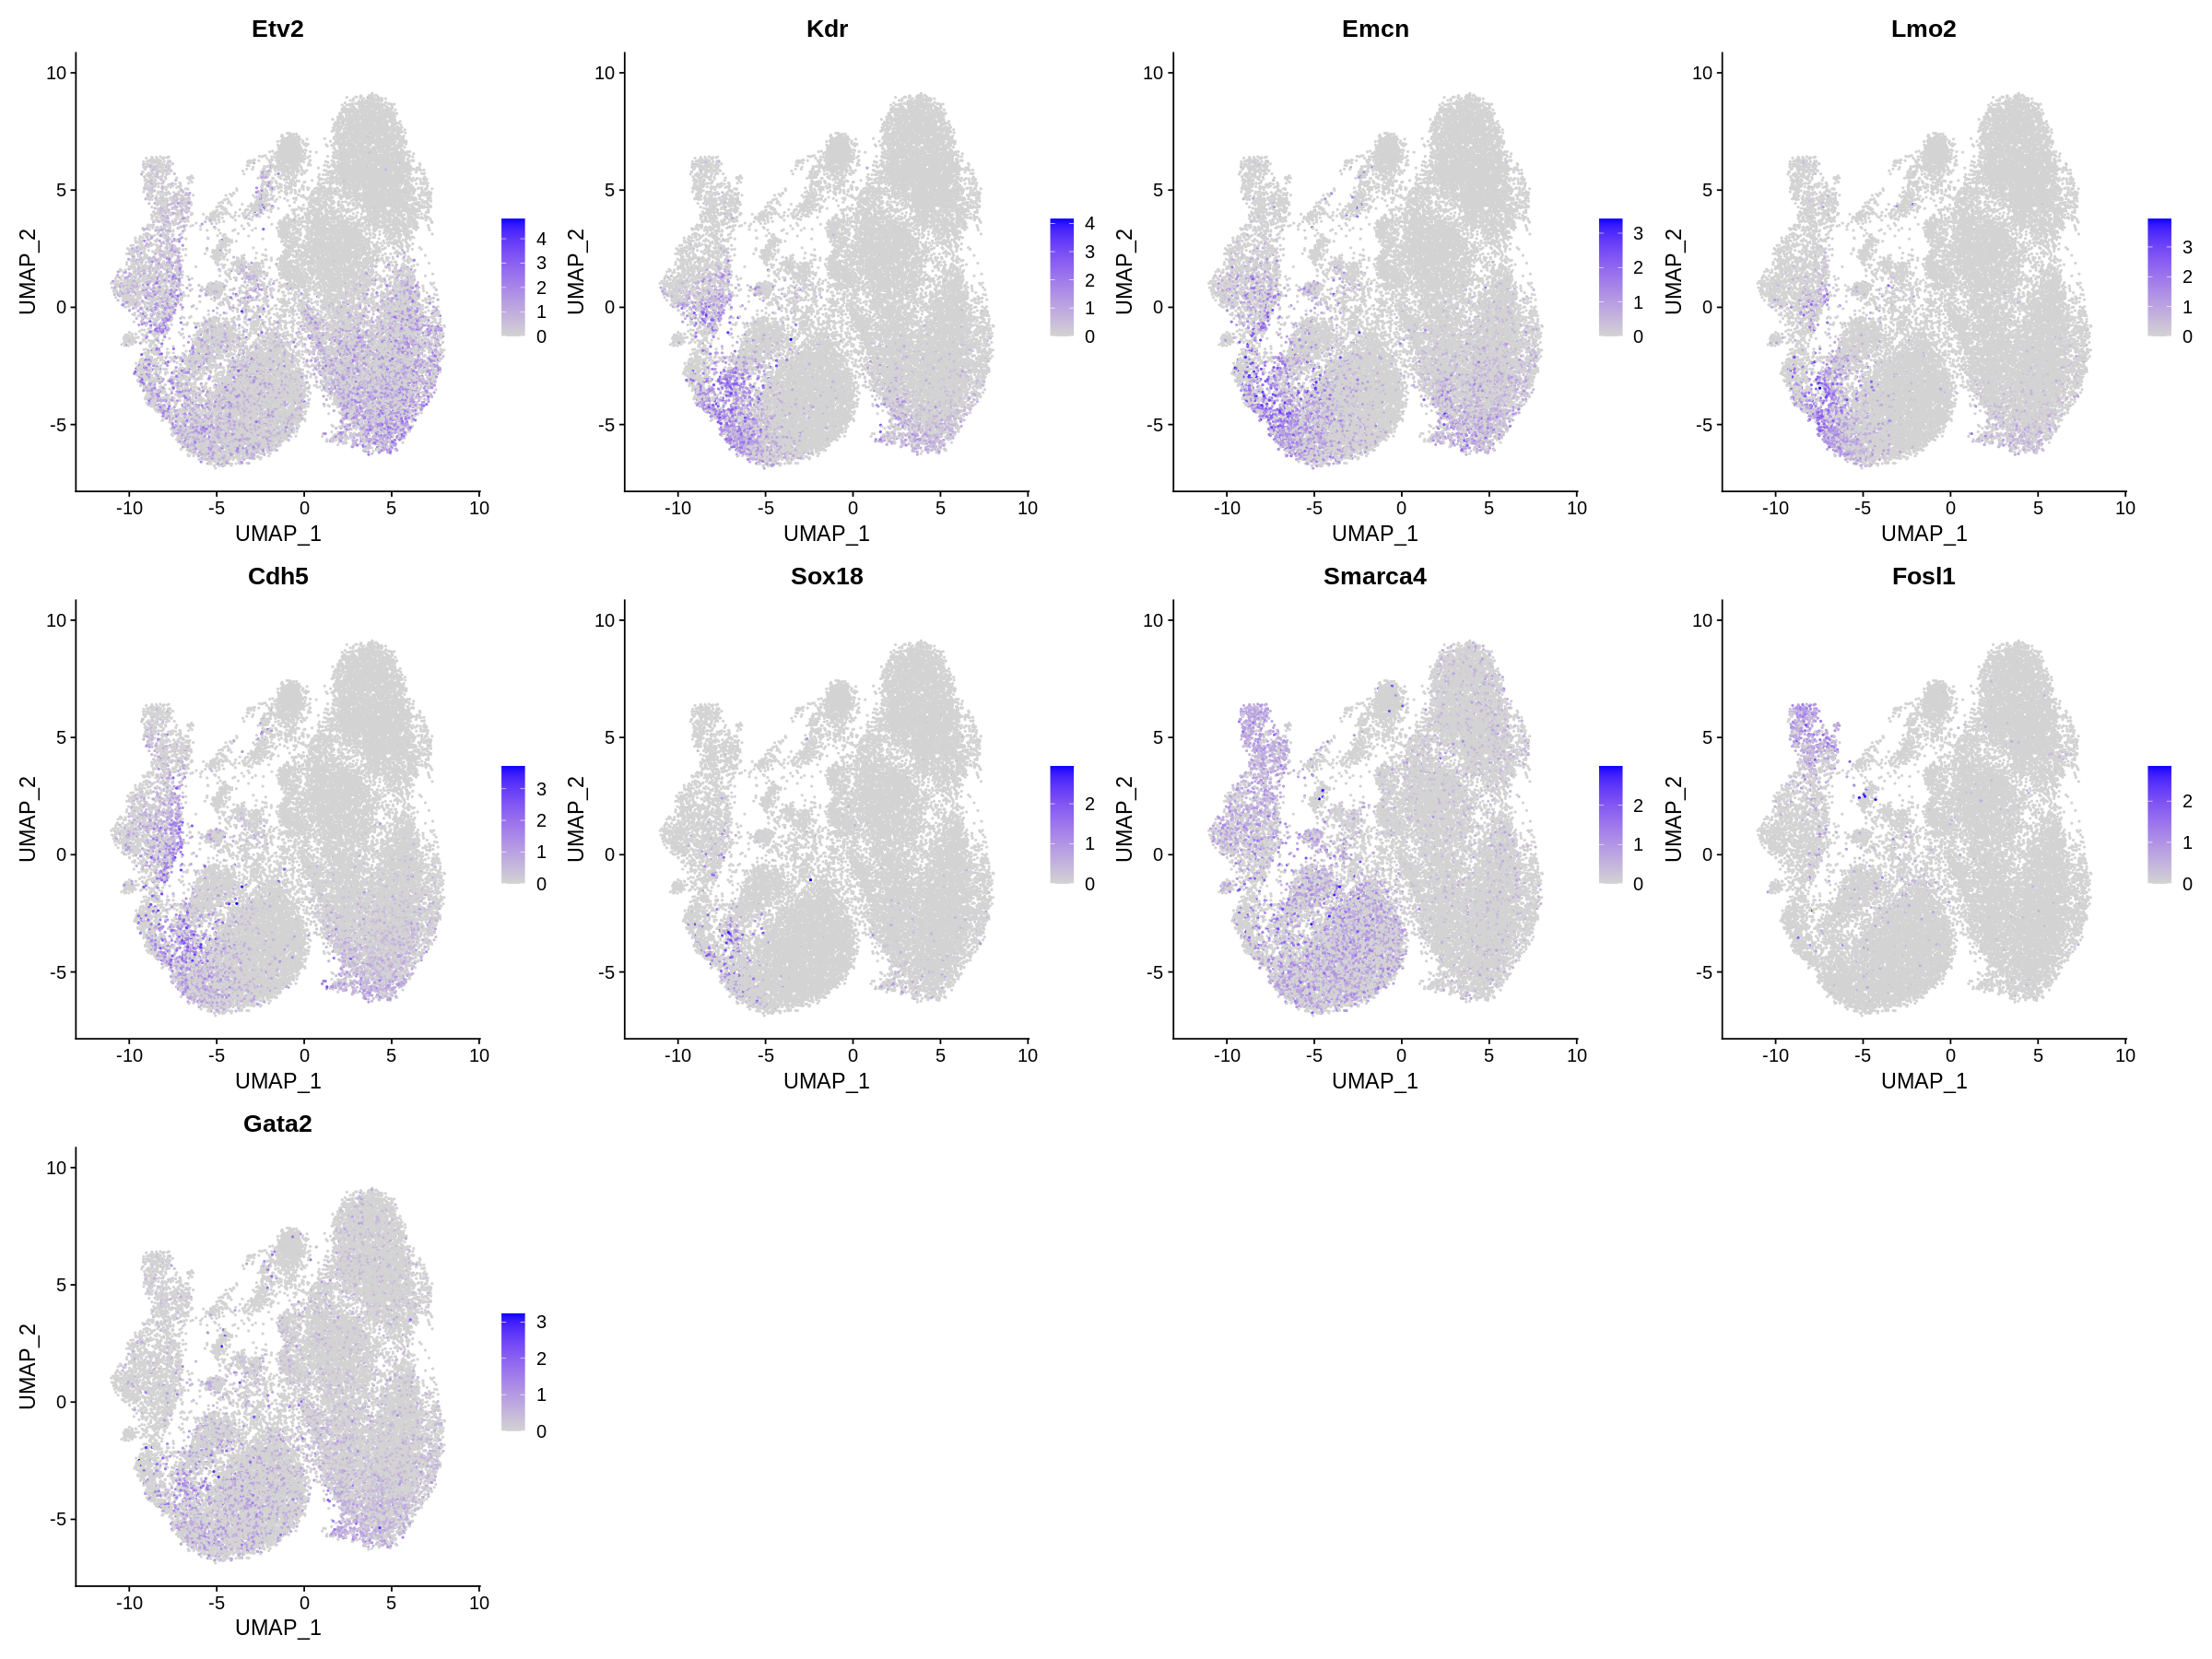

In [31]:
options(repr.plot.width = 20, repr.plot.height = 15)
FeaturePlot(so_D7b, dims = c(1, 2), features = genes, pt.size = 0.25, cols = c('lightgrey', 'blue'), ncol = 4)

### Identify cluster-speicifc genes

In [32]:
Idents(so_D7b) <- 'cluster'
so_markers <- FindAllMarkers(so_D7b, test.use = "wilcox",, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [33]:
so_markers %>%
  group_by(cluster) %>% 
  top_n(n = 20, wt = avg_logFC) %>%
  print(n = 10000)

# A tibble: 260 x 7
# Groups:   cluster [13]
        p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene         
        <dbl>     <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>        
  1 0.            1.14  0.74  0.279 0.        0       Sfrp2        
  2 0.            0.870 0.46  0.139 0.        0       Dlk1         
  3 0.            0.746 0.856 0.383 0.        0       Matn2        
  4 0.            0.697 0.998 0.899 0.        0       mt-Nd3       
  5 0.            0.675 1     0.965 0.        0       mt-Co2       
  6 0.            0.666 0.903 0.616 0.        0       Rbp1         
  7 0.            0.634 0.952 0.724 0.        0       Prdx4        
  8 0.            0.611 0.876 0.573 0.        0       Sfrp1        
  9 0.            0.606 0.893 0.55  0.        0       Npnt         
 10 0.            0.594 0.647 0.236 0.        0       Nov          
 11 0.            0.593 0.863 0.508 0.        0       Lox          
 12 0.            0.589 1     0.994 0.        0       Fth1         
 13

In [34]:
Sys.time() - start_time0

Time difference of 46.19246 mins

In [35]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.1                farver_2.0.3               
 [3] forcats_0.5.0               stringr_1.4.0              
 [5] dplyr_1.0.2                 purrr_0.3.4                
 [7] readr_1.3.1                 tidyr_1.1.2                
 [

In [36]:
Sys.time() - start_time0

Time difference of 46.19382 mins

In [37]:
## sessionInfo

In [38]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.1                farver_2.0.3               
 [3] forcats_0.5.0               stringr_1.4.0              
 [5] dplyr_1.0.2                 purrr_0.3.4                
 [7] readr_1.3.1                 tidyr_1.1.2                
 [